In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the dataset files



Saving utils.py to utils.py


In [5]:
import torch
print("GPU available: ", torch.cuda.is_available())
print("GPU name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU available:  True
GPU name:  Tesla T4


In [ ]:
!pip install tensorflow opencv-python matplotlib


Epoch: 0
Train - Loss: 640.2515 Accuracy: 0.7559
Valid - Loss: 51.4694 Accuracy: 0.9105
Epoch: 1
Train - Loss: 109.5797 Accuracy: 0.9591
Valid - Loss: 23.8046 Accuracy: 0.9612
Epoch: 2
Train - Loss: 56.7919 Accuracy: 0.9789
Valid - Loss: 25.2761 Accuracy: 0.9683
Epoch: 3
Train - Loss: 44.0227 Accuracy: 0.9841
Valid - Loss: 26.5107 Accuracy: 0.9589
Epoch: 4
Train - Loss: 38.9279 Accuracy: 0.9862
Valid - Loss: 23.0368 Accuracy: 0.9668
Epoch: 5
Train - Loss: 29.4953 Accuracy: 0.9886
Valid - Loss: 63.7337 Accuracy: 0.9229
Epoch: 6
Train - Loss: 27.8266 Accuracy: 0.9897
Valid - Loss: 12.5844 Accuracy: 0.9778
Epoch: 7
Train - Loss: 22.5727 Accuracy: 0.9916
Valid - Loss: 34.1161 Accuracy: 0.9536
Epoch: 8
Train - Loss: 19.9191 Accuracy: 0.9930
Valid - Loss: 39.8160 Accuracy: 0.9520
Epoch: 9
Train - Loss: 16.2883 Accuracy: 0.9940
Valid - Loss: 10.3298 Accuracy: 0.9773
Epoch: 10
Train - Loss: 21.0235 Accuracy: 0.9917
Valid - Loss: 16.8965 Accuracy: 0.9756
Epoch: 11
Train - Loss: 17.0676 Accuracy

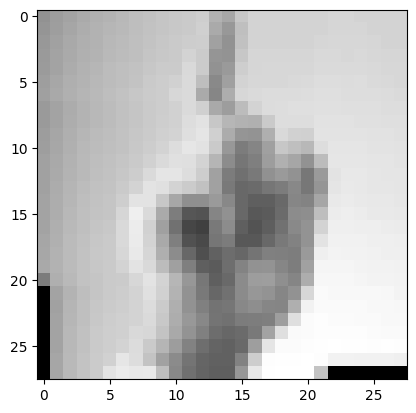

In [29]:
#import IPython
#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import utils
import os
os.environ["TORCH_LOGS"] = "+dynamo"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv(r"/content/data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv(r"/content/data/asl_data/sign_mnist_valid.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

#model = torch.compile(base_model.to(device))
model = base_model.to(device)
model
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
new_x_0.shape
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
trans = transforms.Compose([
    transforms.RandomRotation(10)
])
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))  # Updated
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += utils.get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += utils.get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()
torch.save(base_model, 'model.pth')


Epoch: 1/20
Train - Loss: 657.7990 Accuracy: 0.7502
Valid - Loss: 64.8313 Accuracy: 0.8953
Epoch: 2/20
Train - Loss: 111.8165 Accuracy: 0.9596
Valid - Loss: 34.4943 Accuracy: 0.9571
Epoch: 3/20
Train - Loss: 61.7444 Accuracy: 0.9770
Valid - Loss: 16.6148 Accuracy: 0.9844
Epoch: 4/20
Train - Loss: 43.4336 Accuracy: 0.9839
Valid - Loss: 22.2716 Accuracy: 0.9750
Epoch: 5/20
Train - Loss: 32.5358 Accuracy: 0.9869
Valid - Loss: 46.2237 Accuracy: 0.9271
Epoch: 6/20
Train - Loss: 28.8714 Accuracy: 0.9889
Valid - Loss: 23.3449 Accuracy: 0.9656
Epoch: 7/20
Train - Loss: 28.2782 Accuracy: 0.9892
Valid - Loss: 17.1262 Accuracy: 0.9798
Epoch: 8/20
Train - Loss: 22.5834 Accuracy: 0.9920
Valid - Loss: 22.9374 Accuracy: 0.9644
Epoch: 9/20
Train - Loss: 26.4289 Accuracy: 0.9904
Valid - Loss: 24.5042 Accuracy: 0.9657
Epoch: 10/20
Train - Loss: 14.2141 Accuracy: 0.9945
Valid - Loss: 20.9071 Accuracy: 0.9803
Epoch: 11/20
Train - Loss: 17.7671 Accuracy: 0.9932
Valid - Loss: 17.1055 Accuracy: 0.9759
Epoch:

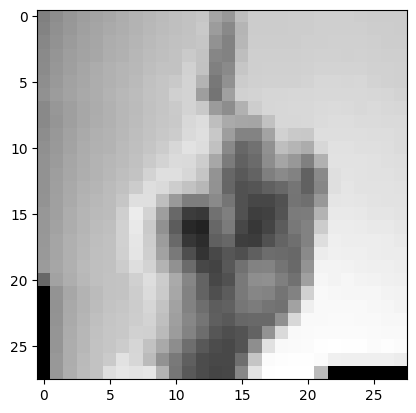

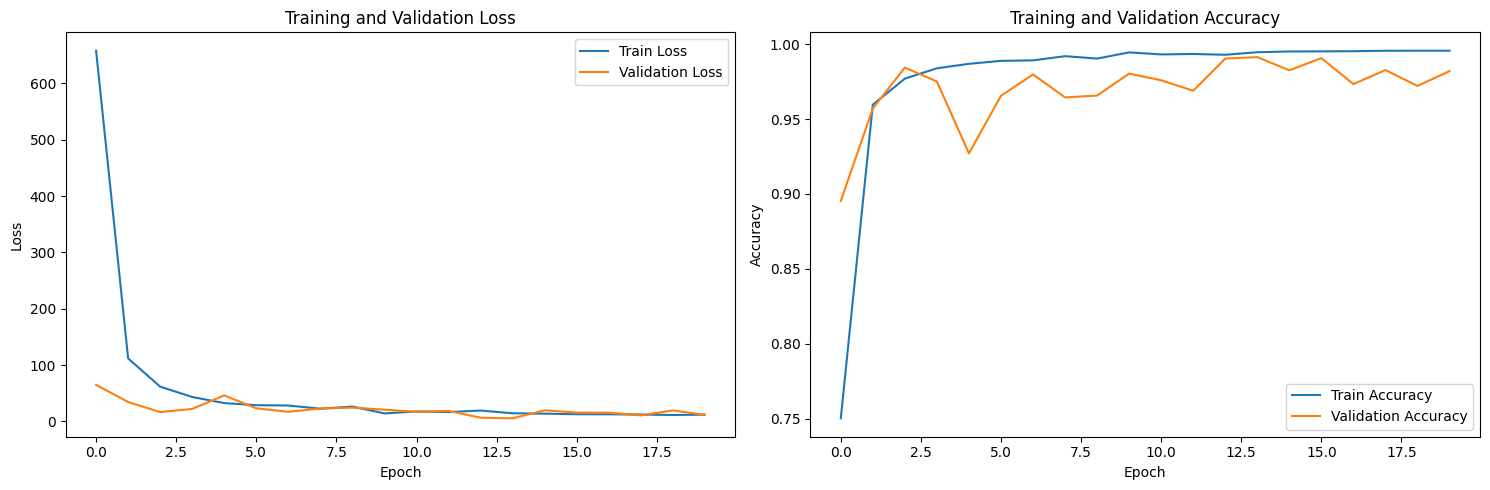

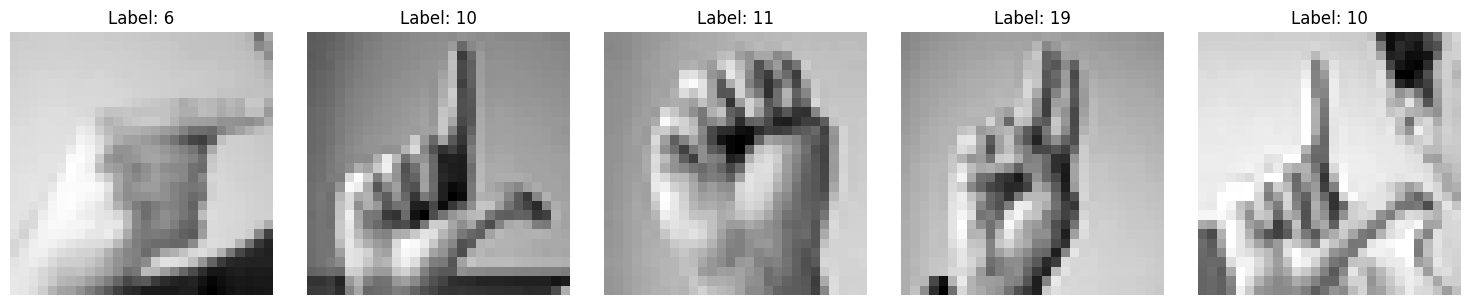

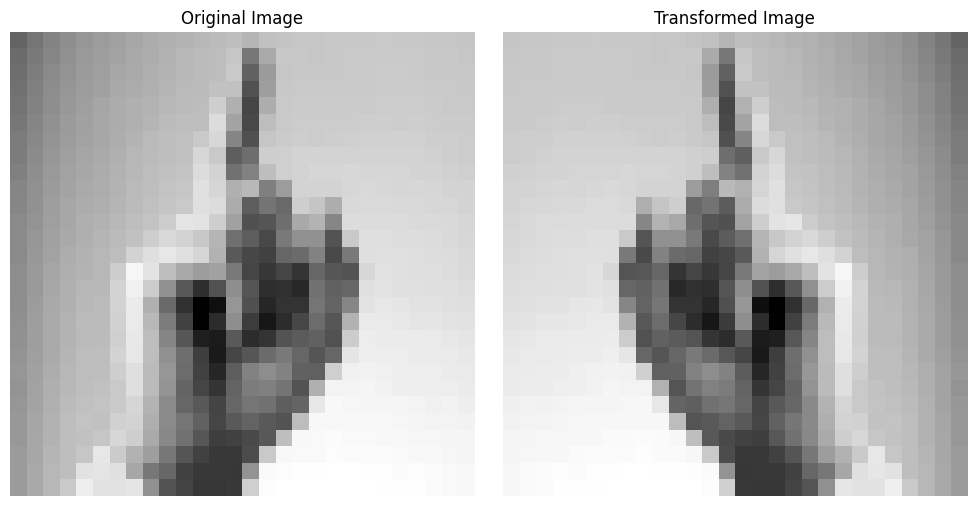

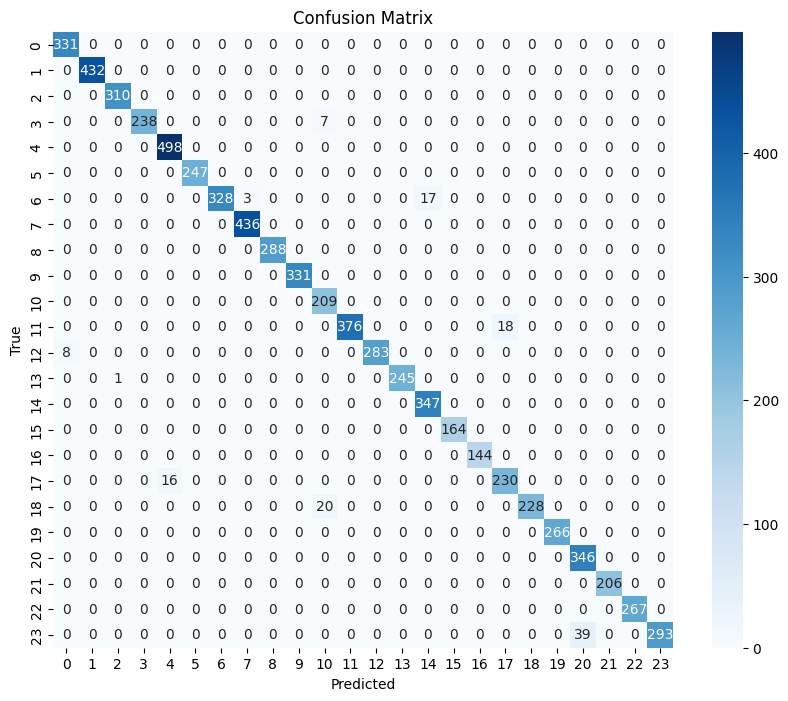

In [40]:
#import IPython
#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import utils
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
os.environ["TORCH_LOGS"] = "+dynamo"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv(r"/content/data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv(r"/content/data/asl_data/sign_mnist_valid.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

#model = torch.compile(base_model.to(device))
model = base_model.to(device)
model
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
new_x_0.shape
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
trans = transforms.Compose([
    transforms.RandomRotation(10)
])
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')
def plot_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        img = img.cpu().numpy().squeeze()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label.item()}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_transformed_image(original, transformed):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(F.to_pil_image(original), cmap='gray')
    ax1.set_title("Original Image")
    ax1.axis('off')
    ax2.imshow(F.to_pil_image(transformed), cmap='gray')
    ax2.set_title("Transformed Image")
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(valid_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')

    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(valid_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Update the train and validate functions to return loss and accuracy
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += utils.get_batch_accuracy(output, y, train_N)
    return loss, accuracy

def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += utils.get_batch_accuracy(output, y, valid_N)
    return loss, accuracy

# Main training loop with history tracking
epochs = 20
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}/{epochs}')
    train_loss, train_accuracy = train()
    valid_loss, valid_accuracy = validate()

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Train - Loss: {train_loss:.4f} Accuracy: {train_accuracy:.4f}')
    print(f'Valid - Loss: {valid_loss:.4f} Accuracy: {valid_accuracy:.4f}')

# Plot training history
plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Plot sample images
plot_sample_images(train_data)

# Plot a transformed image
sample_img, _ = train_data[0]
transformed_img = random_transforms(sample_img)
plot_transformed_image(sample_img, transformed_img)

# Generate predictions for confusion matrix
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in valid_loader:
        output = model(x)
        _, predicted = torch.max(output, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)

torch.save(base_model, 'model.pth')


In [13]:
!pip install opencv-python


In [14]:
import cv2
import torch
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from utils import MyConvBlock

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model
model = torch.load('model.pth', map_location=device)
model.eval()

# Preprocessing for webcam input
IMG_WIDTH = 28
IMG_HEIGHT = 28
preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True),  # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # Convert to grayscale
])

alphabet = "abcdefghiklmnopqrstuvwxy"

# Webcam input handling
cap = cv2.VideoCapture(0)  # 0 for the default camera
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = torch.from_numpy(frame).permute(2, 0, 1)  # Convert to torch tensor
    image = preprocess_trans(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make prediction
    output = model(image)
    prediction = output.argmax(dim=1).item()
    predicted_letter = alphabet[prediction]

    # Display the frame with the predicted letter
    cv2.putText(frame, f'Predicted: {predicted_letter}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.imshow('Webcam', frame)

    # Break on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



<ipython-input-14-b5caf5e991ee>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth', map_location=device)


for webcam input (run in jupyter notebook)

In [ ]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
import numpy as np
from collections import deque

# Define MyConvBlock class
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

# Load the model
model = torch.load('model.pth', map_location=torch.device('cpu'))
model.eval()

# Define preprocessing transforms
preprocess_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the alphabet
alphabet = "abcdefghiklmnopqrstuvwxy" #not j and z as they don't have still images/signs

# Function to preprocess the frame
def preprocess_frame(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    processed = preprocess_trans(rgb_frame)
    return processed.unsqueeze(0)

# Function to add text to frame
def add_text(frame, text, position, font_scale=0.7, color=(255, 255, 255), thickness=2):
    cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

# Initialize webcam
cap = cv2.VideoCapture(0)

# Initialize a deque to store recent predictions
recent_predictions = deque(maxlen=10)

# Flag to control the main loop
running = True

while running:
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to grab frame")
        break

    # Create a region of interest (ROI) in the center of the frame
    height, width = frame.shape[:2]
    roi_size = min(height, width) // 2
    top = (height - roi_size) // 2
    left = (width - roi_size) // 2
    roi = frame[top:top+roi_size, left:left+roi_size]

    # Draw ROI rectangle
    cv2.rectangle(frame, (left, top), (left+roi_size, top+roi_size), (0, 255, 0), 2)

    # Preprocess the ROI and get prediction
    input_tensor = preprocess_frame(roi)
    with torch.no_grad():
        output = model(input_tensor)
        prediction = output.argmax(dim=1).item()
        predicted_letter = alphabet[prediction]

    # Add prediction to recent predictions
    recent_predictions.append(predicted_letter)

    # Get most common prediction
    most_common = max(set(recent_predictions), key=recent_predictions.count) if recent_predictions else ''

    # Add text to frame
    add_text(frame, f"Predicted: {most_common}", (10, 30), 1, (0, 255, 0), 2)
    add_text(frame, "Place hand in green box", (10, height - 90))
    add_text(frame, "Press 'q' or 'Esc' to quit", (10, height - 60))
    add_text(frame, "Press 'c' to clear predictions", (10, height - 30))

    # Display the frame
    cv2.imshow('ASL Letter Recognition', frame)

    # Check for key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or key == 27:  # 'q' or ESC
        running = False
    elif key == ord('c'):  # 'c' to clear recent predictions
        recent_predictions.clear()

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()
print("Webcam stopped and windows closed.")